<a href="https://colab.research.google.com/github/zhang-linnng/convex_restriction_transformed/blob/main/0910updatedSOCP_case123nick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [3]:
!ipopt --version

Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



In [4]:
!which ipopt

bin/ipopt


# Import libraries

In [5]:
from __future__ import division
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from mpl_toolkits.mplot3d import Axes3D
import random
import pandas as pd
import math
import json
import pickle
import cmath
import sys

random.seed(1234321)

# Project folder

In [6]:
def create_dir(path):
    isExist = os.path.exists(path)

    if not isExist:
        # Create a new directory if it does not exist
        os.makedirs(path)
        print("The new directory %s is created!" % (path))

In [7]:
project_path = "/content/gdrive/MyDrive/2023Projects/convex_restriction/case123nick/"
ourMethod_path = project_path  + "our_method/"
socp_path = project_path  + "socp/"
# sdp_path = project_path  + "sdp/"
newtonRaphson_path = project_path  + "newton_raphson/"
settings_path = project_path + "grid_case123nick/"

In [8]:
create_dir(settings_path)
create_dir(ourMethod_path)
create_dir(socp_path)
create_dir(newtonRaphson_path)

# Grid representation

## Parameters

In [9]:
import scipy.io as sio

# mat_contents = sio.loadmat(settings_path + mat_fname)
branch_contents = sio.loadmat(settings_path + 'branch_case123nick.mat')
bus_contents = sio.loadmat(settings_path + 'bus_case123nick.mat')
gen_contents = sio.loadmat(settings_path + 'gen_case123nick.mat')

print(branch_contents.keys())
print(bus_contents.keys())
print(gen_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'branch'])
dict_keys(['__header__', '__version__', '__globals__', 'bus'])
dict_keys(['__header__', '__version__', '__globals__', 'gen'])


In [10]:
## branch data: fbus(0), tbus(1), r(2), x(3), b(4)
## bus data: bus(0), type(1), Pd(2), Qd(3), Vmx(11), Vmn(12)
## gen data: bus(0), Pg(1), Qg(2), Qmax(3), Qmin(4), Pmax(8), Pmin(9)

branch_data = branch_contents['branch']
bus_data = bus_contents['bus']
gen_data = gen_contents['gen']

branch_array = np.concatenate([branch_data[:,0:1], branch_data[:,1:2], branch_data[:,2:3], branch_data[:,3:4], branch_data[:,4:5]], axis=1)
branch_df = pd.DataFrame(branch_array, columns = ['fbus','tbus','r','x','b'])
branch_df['fbus'] = branch_df['fbus'].apply(lambda x: int(x))
branch_df['tbus'] = branch_df['tbus'].apply(lambda x: int(x))

bus_array = np.concatenate([bus_data[:,0:1], bus_data[:,1:2], bus_data[:,2:3], bus_data[:,3:4], bus_data[:,11:12], bus_data[:,12:13]], axis=1)
bus_df = pd.DataFrame(bus_array, columns = ['bus','type','Pd','Qd','Vmx','Vmn'])
bus_df['bus'] = bus_df['bus'].apply(lambda x: int(x))
bus_df['type'] = bus_df['type'].apply(lambda x: int(x))

gen_array = np.concatenate([gen_data[:,0:1], gen_data[:,1:2], gen_data[:,2:3], gen_data[:,3:4], gen_data[:,4:5], gen_data[:,8:9], gen_data[:,9:10]], axis=1)
gen_df = pd.DataFrame(gen_array, columns = ['bus','Pg','Qg','Qmax','Qmin','Pmax','Pmin'])
gen_df['bus'] = gen_df['bus'].apply(lambda x: int(x))

In [11]:
branch_df = branch_df.sort_values(by=['fbus', 'tbus'], ascending=True)

In [12]:
branch_df.head()

,fbus,tbus,r,x,b
0,1,2,0.002546,0.002581,0.000003
1,1,3,0.003637,0.003687,0.000004
2,1,7,0.001502,0.003539,0.000006
3,3,4,0.002909,0.002949,0.000003
4,3,5,0.004728,0.004793,0.000005


In [13]:
gen_df.head()

,bus,Pg,Qg,Qmax,Qmin,Pmax,Pmin
0,114,0,0,200,-200,200,-200


In [14]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn
0,1,1,0.04,0.02,1.2,0.8
1,2,1,0.02,0.01,1.2,0.8
2,3,1,0.00,0.00,1.2,0.8
3,4,1,0.04,0.02,1.2,0.8
4,5,1,0.02,0.01,1.2,0.8


In [15]:
r_ij = branch_df["r"].to_numpy()
x_ij = branch_df["x"].to_numpy()
g_ij = r_ij/(r_ij**2+x_ij**2)
b_ij = x_ij/(r_ij**2+x_ij**2)
branch_df["conductance(g)"] = g_ij
branch_df["susceptance(b)"] = b_ij
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b)
0,1,2,0.002546,0.002581,0.000003,193.723868,196.391040
1,1,3,0.003637,0.003687,0.000004,135.606729,137.473712
2,1,7,0.001502,0.003539,0.000006,101.623767,239.402135
3,3,4,0.002909,0.002949,0.000003,169.508376,171.842151
4,3,5,0.004728,0.004793,0.000005,104.312855,105.749003


In [16]:
count_lines_df = branch_df.groupby(['fbus', 'tbus']).count()
count_lines_df.head()
branches = count_lines_df.index.to_list()
branches_list = [(int(x[0]), int(x[1])) for x in branches]
print(branches_list)

nodes = bus_df['bus'].to_list()
nodes_list = [int(x) for x in nodes]
print(nodes_list)

num_nodes = len(nodes_list)
num_branches = len(branches_list)
print('num_nodes:', num_nodes)
print('num_branches:', num_branches)

[(1, 2), (1, 3), (1, 7), (3, 4), (3, 5), (5, 6), (7, 8), (8, 9), (8, 12), (8, 13), (9, 14), (13, 18), (13, 34), (13, 52), (14, 10), (14, 11), (15, 16), (15, 17), (18, 19), (18, 21), (18, 35), (19, 20), (21, 22), (21, 23), (23, 24), (23, 25), (25, 26), (25, 28), (26, 27), (26, 31), (27, 33), (28, 29), (29, 30), (31, 32), (34, 15), (35, 36), (35, 40), (36, 37), (36, 38), (38, 39), (40, 41), (40, 42), (42, 43), (42, 44), (44, 45), (44, 47), (45, 46), (47, 48), (47, 49), (49, 50), (50, 51), (52, 53), (53, 54), (54, 55), (54, 57), (55, 56), (57, 58), (57, 60), (58, 59), (60, 62), (60, 67), (62, 63), (63, 64), (64, 65), (65, 66), (67, 68), (67, 72), (67, 97), (68, 69), (69, 70), (70, 71), (72, 73), (72, 76), (73, 74), (74, 75), (76, 77), (76, 86), (77, 78), (78, 79), (78, 80), (80, 81), (81, 82), (81, 84), (82, 83), (84, 85), (86, 87), (87, 88), (87, 89), (89, 90), (89, 91), (91, 92), (91, 93), (93, 94), (93, 95), (95, 96), (97, 98), (97, 101), (98, 99), (99, 100), (101, 102), (101, 105), (1

In [17]:
bus_to_numeric = dict()

for k in range(num_nodes):
    node_idx = nodes_list[k]
    bus_to_numeric[node_idx] = k

bus_to_neighbors = dict()
for edge in branches_list:
    fbus = edge[0]
    tbus = edge[1]
    if fbus not in bus_to_neighbors.keys():
        bus_to_neighbors[fbus] = [tbus]
    else:
        bus_to_neighbors[fbus] += [tbus]

    if tbus not in bus_to_neighbors.keys():
        bus_to_neighbors[tbus] = [fbus]
    else:
        bus_to_neighbors[tbus] += [fbus]

print('bus_to_numeric:', bus_to_numeric)
print('bus_to_neighbors:', bus_to_neighbors)


bus_to_numeric: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113}
bus_to_neighbors: {1: [2, 3, 7, 114], 2: [1], 3: [1, 4, 5], 7

In [18]:
numbering_links = dict()
for i in range(num_branches):
    fbus = branch_df.iloc[i, 0]
    tbus = branch_df.iloc[i, 1]
    numbering_links[i] = (fbus, tbus)
print('numbering_links:', numbering_links)

numbering_links: {0: (1, 2), 1: (1, 3), 2: (1, 7), 3: (3, 4), 4: (3, 5), 5: (5, 6), 6: (7, 8), 7: (8, 9), 8: (8, 12), 9: (8, 13), 10: (9, 14), 11: (13, 18), 12: (13, 34), 13: (13, 52), 14: (14, 10), 15: (14, 11), 16: (15, 16), 17: (15, 17), 18: (18, 19), 19: (18, 21), 20: (18, 35), 21: (19, 20), 22: (21, 22), 23: (21, 23), 24: (23, 24), 25: (23, 25), 26: (25, 26), 27: (25, 28), 28: (26, 27), 29: (26, 31), 30: (27, 33), 31: (28, 29), 32: (29, 30), 33: (31, 32), 34: (34, 15), 35: (35, 36), 36: (35, 40), 37: (36, 37), 38: (36, 38), 39: (38, 39), 40: (40, 41), 41: (40, 42), 42: (42, 43), 43: (42, 44), 44: (44, 45), 45: (44, 47), 46: (45, 46), 47: (47, 48), 48: (47, 49), 49: (49, 50), 50: (50, 51), 51: (52, 53), 52: (53, 54), 53: (54, 55), 54: (54, 57), 55: (55, 56), 56: (57, 58), 57: (57, 60), 58: (58, 59), 59: (60, 62), 60: (60, 67), 61: (62, 63), 62: (63, 64), 63: (64, 65), 64: (65, 66), 65: (67, 68), 66: (67, 72), 67: (67, 97), 68: (68, 69), 69: (69, 70), 70: (70, 71), 71: (72, 73), 72:

In [19]:
# incidence matrix
E = np.zeros((num_branches, num_nodes))
for m in range(num_branches):
    f_end = branch_df.iloc[m, 0]
    t_end = branch_df.iloc[m, 1]

    col1 = bus_to_numeric[f_end]
    col2 = bus_to_numeric[t_end]

    if col1 < col2:
        E[m, col1] = 1
        E[m, col2] = -1
    else:
        E[m, col1] = -1
        E[m, col2] = 1

print('E:', E)

E: [[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 1.  0.  0. ...  0.  0. -1.]]


In [20]:
gen_set_mask = bus_df['type']>1
gen_set = bus_df['bus'][gen_set_mask]
gen_rows = np.array(range(num_nodes))[gen_set_mask]
print('gen_set:\n', gen_set)
print('gen_rows:\n', gen_rows)

gen_set:
 113    114
Name: bus, dtype: int64
gen_rows:
 [113]


In [21]:
bus_lists = bus_df['bus'].to_numpy()
print(bus_lists.shape)
print(bus_lists)

(114,)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114]


In [22]:
branch_df['index'] = branch_df.index
branch_df.head()

b_for_lines = b_ij.reshape(-1,1)
g_for_lines = g_ij.reshape(-1,1)

##  Vectorize power flow equations

### Define matrices

In [23]:
G_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_a[row, col] = -g_ij[col]

            else: # if row < neighbor
                G_a[row, col] = -g_ij[col]


B_a = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_a[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_a[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_a[row, col] = b_ij[col]


print('G_a:', G_a.shape)
print('B_a:', B_a.shape)

G_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    G_hat[row, col] = g_ij[m]
    G_hat[col, row] = g_ij[m]

print('G_hat:', G_hat.shape)


d_active = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_active[row, 0] = np.sum(G_hat[row,:])

print('d_active:', d_active.shape)

A = np.block([
    G_a, B_a, d_active
])
print('A:', A.shape)

G_a: (114, 113)
B_a: (114, 113)
G_hat: (114, 114)
d_active: (114, 1)
A: (114, 227)


In [24]:
G_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            G_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]


            if row > neighbor_idx: # if row > neighbor
                G_r[row, col] = g_ij[col]

            else: # if row < neighbor
                G_r[row, col] = -g_ij[col]


B_r = np.zeros((num_nodes, num_branches))
for row in range(num_nodes):
    for col in range(num_branches):
        row_bus = bus_df['bus'].iloc[row]
        end1 = branch_df.iloc[col, 0]
        end2 = branch_df.iloc[col, 1]
        edge = (end1, end2)

        if row_bus not in edge:
            B_r[row, col] = 0

        else: # if bus in edge
            if edge[0] == row_bus:
                neighbor = edge[1]
            else:
                neighbor = edge[0]

            # convert bus no. to numerical indexes
            neighbor_idx = bus_to_numeric[neighbor]

            if row > neighbor_idx: # if row > neighbor
                B_r[row, col] = -b_ij[col]

            else: # if row < neighbor
                B_r[row, col] = -b_ij[col]


print('G_r:', G_r.shape)
print('B_r:', B_r.shape)


B_hat = np.zeros((num_nodes, num_nodes))
for m in range(num_branches):
    end1 = branch_df.iloc[m, 0]
    end2 = branch_df.iloc[m, 1]

    row = bus_to_numeric[end1]
    col = bus_to_numeric[end2]

    B_hat[row, col] = b_ij[m]
    B_hat[col, row] = b_ij[m]

print('B_hat:', B_hat.shape)

d_reactive = np.zeros((num_nodes, 1))
for row in range(num_nodes):

    d_reactive[row, 0] = np.sum(B_hat[row,:])

print('d_reactive:', d_reactive.shape)

R = np.block([
    B_r, G_r, d_reactive
])
print('R:', R.shape)

G_r: (114, 113)
B_r: (114, 113)
B_hat: (114, 114)
d_reactive: (114, 1)
R: (114, 227)


### Power flow equations

In [25]:
def p_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return G_a @ np.sqrt(1-z**2) + B_a @ z + d_active


def q_in_voltage(theta):

    x = theta.reshape(-1,1)
    z = np.sin(E@x)

    return B_r @ np.sqrt(1-z**2) + G_r @ z + d_reactive

nominal_angle = np.zeros(num_nodes)
p = p_in_voltage(nominal_angle)
q = q_in_voltage(nominal_angle)
print(p)
print(q)

[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.68434189e-14]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.84217094e-14]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.0000000

## Active and reactive demands

In [26]:
bus_df['Pd'] = bus_df['Pd'] * 10
bus_df['Qd'] = bus_df['Qd'] * 10

## Nodal power bounds

In [27]:
bus_df['Pmax'] = bus_df['bus']
bus_df['Pmin'] = bus_df['Pd']
bus_df['Qmax'] = bus_df['Pd']
bus_df['Qmin'] = bus_df['Pd']
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.4,0.2,1.2,0.8,1,0.4,0.4,0.4
1,2,1,0.2,0.1,1.2,0.8,2,0.2,0.2,0.2
2,3,1,0.0,0.0,1.2,0.8,3,0.0,0.0,0.0
3,4,1,0.4,0.2,1.2,0.8,4,0.4,0.4,0.4
4,5,1,0.2,0.1,1.2,0.8,5,0.2,0.2,0.2


In [28]:
gen_df_copy = gen_df.copy()
gen_df_copy = gen_df_copy.set_index('bus')
gen_df_copy.head()

,Pg,Qg,Qmax,Qmin,Pmax,Pmin
bus,,,,,,
114,0,0,200,-200,200,-200


In [29]:
for i in range(num_nodes):
    bus = bus_df.iloc[i, 0]
    type = bus_df.iloc[i, 1]
    if type > 1: # generator or slack(reference) buses, copy everything
        bus_df.loc[i, 'Pmax']= gen_df_copy.loc[bus, 'Pmax']
        # bus_df.loc[i, 'Pmin']= gen_df_copy.loc[bus, 'Pmin']
        bus_df.loc[i, 'Pmin']= 0
        bus_df.loc[i, 'Qmax']= gen_df_copy.loc[bus, 'Qmax']
        bus_df.loc[i, 'Qmin']= gen_df_copy.loc[bus, 'Qmin']

    else:
       # load buses, Pmax = -Pd; Pmin

        bus_df.loc[i, 'Pmax'] = -bus_df['Pd'][i]
        bus_df.loc[i, 'Pmin'] = -10. # set a maximum loading at this bus,
        # based on the generators's capacity, which is 10, I set the maximum loading to be 10

        # # this results in infeasibility
        # bus_df.loc[i, 'Qmax'] = bus_df['Qd'][i] # positive Qmax means maximum reactive power that
        # # this load bus can consume
        # bus_df.loc[i, 'Qmin'] = 0. # postive Q min means that this load bus cannot contribute(generate)
        # # reactive power
        bus_df.loc[i, 'Qmax'] = 10. # this is the maximum reactive power that generator bus can contribute
        bus_df.loc[i, 'Qmin'] = bus_df['Qd'][i]


bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
1,2,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1
2,3,1,0.0,0.0,1.2,0.8,-0.0,-10.0,10.0,0.0
3,4,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
4,5,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1


In [30]:
Pd = bus_df['Pd'].to_numpy()
print('Pd:', Pd)

Qd = bus_df['Qd'].to_numpy()
print('Qd:', Qd)

Qmax = bus_df['Qmax'].to_numpy()
# Qmin = bus_df['Qmin'].to_numpy()
# Pmax = bus_df['Pmax'].to_numpy()
Pmin = bus_df['Pmin'].to_numpy()
print('Qmax shape:', Qmax.shape)

Pd: [0.4  0.2  0.   0.4  0.2  0.4  0.2  0.   0.4  0.2  0.4  0.2  0.   0.
 0.   0.4  0.2  0.   0.4  0.4  0.   0.4  0.   0.4  0.   0.   0.   0.4
 0.4  0.4  0.2  0.2  0.4  0.4  0.4  0.   0.4  0.2  0.2  0.   0.2  0.2
 0.4  0.   0.2  0.2  1.05 2.1  1.4  0.4  0.2  0.4  0.4  0.   0.2  0.2
 0.   0.2  0.2  0.2  0.2  0.4  0.4  0.75 1.4  0.75 0.   0.2  0.4  0.2
 0.4  0.   0.4  0.4  0.4  2.45 0.4  0.   0.4  0.4  0.   0.4  0.2  0.2
 0.4  0.2  0.4  0.4  0.   0.4  0.   0.4  0.   0.4  0.2  0.2  0.   0.4
 0.4  0.4  0.   0.2  0.4  0.4  0.   0.4  0.4  0.   0.4  0.   0.2  0.2
 0.4  0.  ]
Qd: [0.2  0.1  0.   0.2  0.1  0.2  0.1  0.   0.2  0.1  0.2  0.1  0.   0.
 0.   0.2  0.1  0.   0.2  0.2  0.   0.2  0.   0.2  0.   0.   0.   0.2
 0.2  0.2  0.1  0.1  0.2  0.2  0.2  0.   0.2  0.1  0.1  0.   0.1  0.1
 0.2  0.   0.1  0.1  0.75 1.5  0.95 0.2  0.1  0.2  0.2  0.   0.1  0.1
 0.   0.1  0.1  0.1  0.1  0.2  0.2  0.35 1.   0.35 0.   0.1  0.2  0.1
 0.2  0.   0.2  0.2  0.2  1.8  0.2  0.   0.2  0.2  0.   0.2  0.1  0.1
 0

In [31]:
# Load the dictionary from the pickle file
with open(project_path + 'modification_file.pkl', 'rb') as file:
    modification_file = pickle.load(file)

print("modification_file:", modification_file.keys())


modification_file: dict_keys(['new_p_max', 'new_q_min', 'z_interior'])


In [32]:
Qmin = modification_file['new_q_min']
Pmax = modification_file['new_p_max']
# INTERIOR_Z = modification_file['z_interior']

In [33]:
bus_types = []
for i in range(num_nodes):
    match bus_df.iloc[i,1]:
        case 1:
            # print('PQ bus')
            bus_types.append('load')
        case 2:
            # print('PV bus')
            bus_types.append('gen')
        case 3:
            # print('reference bus')
            bus_types.append('slack')
        case _:
            # print('Isolated bus')
            bus_types.append('isolated')

print('bus types:', bus_types)

bus types: ['load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'load', 'slack']


## Tighten bounds

In [34]:
# Pmin = np.ones_like(bus_df['Pmin'].to_numpy()) * (-3)
# Pmin[-1] = 0

## Power flow equations using cp functions

In [35]:
import cvxpy as cp

In [36]:
print('G_a:', G_a.shape)
print('B_a:', B_a.shape)
print('d_active:', d_active.shape)

print('G_r:', G_r.shape)
print('B_r:', B_r.shape)
print('d_reactive:', d_reactive.shape)

G_a: (114, 113)
B_a: (114, 113)
d_active: (114, 1)
G_r: (114, 113)
B_r: (114, 113)
d_reactive: (114, 1)


In [37]:
bus_df.head()

,bus,type,Pd,Qd,Vmx,Vmn,Pmax,Pmin,Qmax,Qmin
0,1,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
1,2,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1
2,3,1,0.0,0.0,1.2,0.8,-0.0,-10.0,10.0,0.0
3,4,1,0.4,0.2,1.2,0.8,-0.4,-10.0,10.0,0.2
4,5,1,0.2,0.1,1.2,0.8,-0.2,-10.0,10.0,0.1


In [38]:
branch_df.head()

,fbus,tbus,r,x,b,conductance(g),susceptance(b),index
0,1,2,0.002546,0.002581,0.000003,193.723868,196.391040,0
1,1,3,0.003637,0.003687,0.000004,135.606729,137.473712,1
2,1,7,0.001502,0.003539,0.000006,101.623767,239.402135,2
3,3,4,0.002909,0.002949,0.000003,169.508376,171.842151,3
4,3,5,0.004728,0.004793,0.000005,104.312855,105.749003,4


## Check solution feasibility

In [39]:
# check if origin is a feasible point
def is_voltage_feasible(theta):

    p = p_in_voltage(theta)
    q = q_in_voltage(theta)

    # print('p_max:\n', np.squeeze(Pmax))
    # print('p:\n', np.squeeze(p))
    # print('p_min:\n', np.squeeze(Pmin))

    # print('q_max:\n', np.squeeze(Qmax))
    # print('q:\n', np.squeeze(q))
    # print('q_min:\n', np.squeeze(Qmin))

    p_values = np.squeeze(p)
    q_values = np.squeeze(q)

    tolerance = -1e-6

    # if np.all(p_values>=Pmin) & np.all(p_values<=Pmax) & np.all(q_values >=Qmin) & np.all(q_values<=Qmax):
    if np.all(p_values-Pmin>=tolerance) & np.all(Pmax-p_values>=tolerance) & np.all(q_values-Qmin>=tolerance) & np.all(Qmax-q_values>=tolerance):

        return True
    else:
        return False


nominal_angle = np.zeros(num_nodes)
is_voltage_feasible(nominal_angle) # Nooope


False

## Cost coefficients

In [40]:
# buscost = np.array(cost_coefficients_list)/20
# np.save(project_path + 'buscost.npy', buscost)
# np.save(project_path + 'distributed_gen_list.npy', distributed_gen_list)
buscost = np.load(project_path + 'buscost.npy')
distributed_gen_list = np.load(project_path + 'distributed_gen_list.npy').tolist()
distributed_gen_indexes = [bus_to_numeric[i] for i in distributed_gen_list]
print('distributed_gen_indexes:', distributed_gen_indexes)
print('buscost:', buscost[distributed_gen_indexes])

distributed_gen_indexes: [0, 2, 6, 7, 12, 13, 14, 17, 20, 22, 24, 25, 26, 35, 39, 43, 51, 53, 56, 66, 71, 77, 80, 88, 90, 92, 96, 100, 104, 107, 109, 113]
buscost: [5.15 3.75 3.4  2.4  1.15 3.25 5.05 2.35 4.35 2.25 4.   1.45 1.25 0.65
 1.15 4.1  3.05 5.4  2.5  4.   4.3  2.1  4.65 0.95 0.1  2.1  2.65 5.6
 0.05 5.65 3.45 4.25]


## SOCP relaxation: minimize total losses

In [41]:
def p_socp(R, I):

    return G_a @ R + B_a @ I + d_active

def q_socp(R, I):

    return B_r @ R + G_r @ I + d_reactive


In [42]:
# # Import packages.
# import cvxpy as cp

# def socp_relaxation():

#     p_max = Pmax.reshape(-1, 1)
#     p_min = Pmin.reshape(-1, 1)
#     q_max = Qmax.reshape(-1, 1)
#     q_min = Qmin.reshape(-1, 1)

#     # Define and solve the CVXPY problem.
#     R = cp.Variable(shape=(num_branches, 1))
#     I = cp.Variable(shape=(num_branches, 1))

#     p = p_socp(R, I)# active nodal power
#     q = q_socp(R, I)# reactive nodal power

#     # objective
#     total_losses = cp.sum(p) # total transmission losses

#     # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
#     # soc_constraints = [
#     #     cp.SOC(c[i].T @ x + d[i], A[i] @ x + b[i]) for i in range(m)
#     # ]

#     # constraints
#     constraints = [
#                     R >= 0,
#                     p <= p_max,
#                     p >= p_min,
#                     q <= q_max,
#                     q >= q_min,
#                     cp.square(R) + cp.square(I) <= 1
#     ]

#     prob = cp.Problem(cp.Minimize(total_losses), constraints)
#     prob.solve()

#     # Print result.
#     print("The optimal value is", prob.value)
#     # print("A solution x is")
#     # print(x.value)
#     # for i in range(m):
#     #     print("SOC constraint %i dual variable solution" % i)
#     #     print(soc_constraints[i].dual_value)

In [43]:
# socp_relaxation()

## SOCP relaxation: minimize total cost

In [44]:
# Import packages.
import cvxpy as cp

def minimize_total_costs():

    p_max = Pmax.reshape(-1, 1)
    p_min = Pmin.reshape(-1, 1)
    q_max = Qmax.reshape(-1, 1)
    q_min = Qmin.reshape(-1, 1)
    gencost = buscost[distributed_gen_indexes].reshape(-1, 1)

    # Define and solve the CVXPY problem.
    R = cp.Variable(shape=(num_branches, 1))
    I = cp.Variable(shape=(num_branches, 1))

    p = p_socp(R, I)# active nodal power
    q = q_socp(R, I)# reactive nodal power

    # objective
    total_costs = cp.sum(gencost.T @ p[distributed_gen_indexes,:]) # total transmission losses

    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
    # soc_constraints = [
    #     cp.SOC(c[i].T @ x + d[i], A[i] @ x + b[i]) for i in range(m)
    # ]

    # constraints
    constraints = [
                    R >= 0,
                    p <= p_max,
                    p >= p_min,
                    q <= q_max,
                    q >= q_min,
                    cp.square(R) + cp.square(I) <= 1
    ]

    prob = cp.Problem(cp.Minimize(total_costs), constraints)
    prob.solve()

    if prob.status in ["infeasible", "unbounded"]:
        print(5*' ' +"Model not solved to (sub)optimality using CVXPY!!!")
        print(5*' ' +"Solver status: ", prob.status)
        sys.exit(0)

    # Print result.
    print("The optimal value is", prob.value)
    # print("A solution x is")
    # print(x.value)
    # for i in range(m):
    #     print("SOC constraint %i dual variable solution" % i)
    #     print(soc_constraints[i].dual_value)

    R_solution = R.value
    I_solution = I.value
    p_solution = p_socp(R_solution, I_solution)
    q_solution = q_socp(R_solution, I_solution)

    results = np.concatenate([p_max, p_solution, p_min, q_max, q_solution, q_min], axis=1)
    column_names = ['p_max', 'p_solution', 'p_min', 'q_max', 'q_solution', 'q_min']
    results_df = pd.DataFrame(results, columns=column_names)
    print(results_df)

    return results_df

In [45]:
# results_df = minimize_total_costs()

In [46]:
# fig, ax1 = plt.subplots(ncols=1, figsize=(10, 3), sharey = True)
# ax1.scatter(range(num_nodes-1), buscost.tolist()[:-1], label=r'$c_i$', facecolors='none', edgecolors='red', s=50)
# ax1.set_ylabel(r'$c_i$')
# ax1.legend()

# ax2 = ax1.twinx()
# ax2.plot(range(num_nodes-1), results_df['p_solution'][:-1], label=r'$P_i$', marker='.', color='blue', linestyle='--')
# ax2.plot(range(num_nodes-1), results_df['p_max'][:-1], label=r'$P_i^{\max}$', color='green', linestyle='-')
# ax2.set_ylabel(r'$P_i$')
# ax2.legend()

# plt.show()

In [47]:
# bus_df['Pd'].sum()

In [48]:
# fig, ax1 = plt.subplots(ncols=1, figsize=(10, 3), sharey = True)
# ax1.scatter(range(num_nodes-1), buscost.tolist()[:-1], label=r'$c_i$', facecolors='none', edgecolors='red', s=50)
# ax1.set_ylabel(r'$c_i$')
# ax1.legend()

# ax2 = ax1.twinx()
# ax2.plot(range(num_nodes-1), results_df['p_solution'][:-1], label=r'$P_i$', marker='.', color='blue', linestyle='--')
# ax2.plot(range(num_nodes-1), results_df['p_min'][:-1], label=r'$P_i^{\min}$', color='green', linestyle='-')
# ax2.set_ylabel(r'$P_i$')
# ax2.legend()

# plt.show()

## SOCP relaxation: state estimation

In [49]:
import pickle

# state_estimation_data = dict()
# state_estimation_data['z_star'] = np.squeeze(z_star)
# state_estimation_data['y_star'] = y_star
# state_estimation_data['y_measurements'] = y_measurements

# # Write the dictionary to a JSON file
# with open(project_path + 'state_estimation_data.pkl', "wb") as pickle_file:
#     pickle.dump(state_estimation_data, pickle_file)

with open(project_path + 'state_estimation_data.pkl', "rb") as pickle_file:
    state_estimation_data = pickle.load(pickle_file)
z_star = state_estimation_data['z_star']
y_star = state_estimation_data['y_star']
y_measurements = state_estimation_data['y_measurements']

In [50]:
p_measurements = y_measurements[:num_nodes].reshape(-1,1)
q_measurements = y_measurements[num_nodes:].reshape(-1,1)
# print('p_measurements:', p_measurements)
# print('q_measurements:', q_measurements)

p_star = y_star[:num_nodes].reshape(-1,1)
q_star = y_star[num_nodes:].reshape(-1,1)
# print('p_star:', p_star)
# print('q_star:', q_star)

In [51]:
# Import packages.
import cvxpy as cp

def socp_state_estimation():

    p_max = Pmax.reshape(-1, 1)
    p_min = Pmin.reshape(-1, 1)
    q_max = Qmax.reshape(-1, 1)
    q_min = Qmin.reshape(-1, 1)

    # Define and solve the CVXPY problem.
    R = cp.Variable(shape=(num_branches, 1))
    I = cp.Variable(shape=(num_branches, 1))

    p = p_socp(R, I)# active nodal power
    q = q_socp(R, I)# reactive nodal power
    print('p:', p.shape)
    print('q:', q.shape)

    # objective
    # total_losses = cp.sum(p) # total transmission losses
    cost = cp.norm(p-p_measurements)**2 +  cp.norm(q-q_measurements)**2
    print('cost:', cost.shape)

    # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
    # soc_constraints = [
    #     cp.SOC(c[i].T @ x + d[i], A[i] @ x + b[i]) for i in range(m)
    # ]

    # constraints
    constraints = [
                    R >= 0,
                    p <= p_max,
                    p >= p_min,
                    q <= q_max,
                    q >= q_min,
                    cp.square(R) + cp.square(I) <= 1
    ]

    # prob = cp.Problem(cp.Minimize(total_losses), constraints)
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()

    # Print result.
    print("The optimal value is", prob.value)
    # print("A solution x is")
    # print(x.value)
    # for i in range(m):
    #     print("SOC constraint %i dual variable solution" % i)
    #     print(soc_constraints[i].dual_value)

    R_solution = R.value
    I_solution = I.value
    p_solution = p_socp(R_solution, I_solution)
    q_solution = q_socp(R_solution, I_solution)

    results = np.concatenate([p_max, p_solution, p_min, q_max, q_solution, q_min], axis=1)
    column_names = ['p_max', 'p_solution', 'p_min', 'q_max', 'q_solution', 'q_min']
    results_df = pd.DataFrame(results, columns=column_names)
    print(results_df)

    return p_solution, q_solution

In [52]:
p_solution, q_solution = socp_state_estimation()

p: (114, 1)
q: (114, 1)
cost: ()
The optimal value is 0.0009393865095949258
        p_max  p_solution  p_min  q_max  q_solution     q_min
0      1.0622    1.054254  -10.0   10.0    4.037651    0.1900
1     -0.0882   -0.095469  -10.0   10.0    0.098541    0.0869
2      0.0157    0.007858  -10.0   10.0   -0.002590   -0.0127
3     -0.1961   -0.205142  -10.0   10.0    0.202598    0.1900
4     -0.0899   -0.096765  -10.0   10.0    0.101399    0.0897
..        ...         ...    ...    ...         ...       ...
109    0.0214    0.012652  -10.0   10.0   -0.008008   -0.0183
110   -0.0915   -0.100333  -10.0   10.0    0.100662    0.0900
111   -0.1003   -0.111037  -10.0   10.0    0.111490    0.0900
112   -0.1846   -0.192677  -10.0   10.0    0.191519    0.1835
113  200.0100   30.370016    0.0  200.0  -10.019841 -200.0100

[114 rows x 6 columns]


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


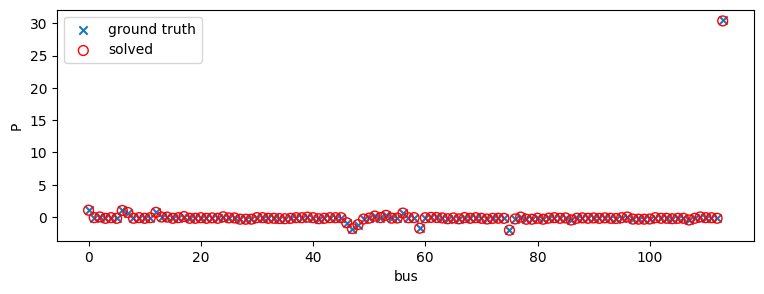

In [54]:
fig, ax1 = plt.subplots(ncols=1, figsize=(9, 3), sharey = True)

ax1.scatter(range(num_nodes), np.squeeze(p_star ), marker='x', label='ground truth')
ax1.scatter(range(num_nodes), np.squeeze(p_solution ), marker='o',
            facecolors='none', edgecolors='red', s=50, label='solved')
ax1.set_xlabel('bus')
ax1.set_ylabel('P')
ax1.legend()
plt.show()

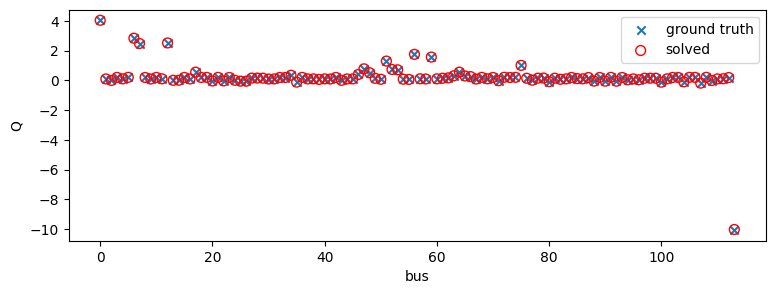

In [55]:
fig, ax1 = plt.subplots(ncols=1, figsize=(9, 3), sharey = True)

ax1.scatter(range(num_nodes), np.squeeze(q_star ), marker='x', label='ground truth')
ax1.scatter(range(num_nodes), np.squeeze(q_solution ), marker='o',
            facecolors='none', edgecolors='red', s=50, label='solved')
ax1.set_xlabel('bus')
ax1.set_ylabel('Q')
ax1.legend()
plt.show()